In [ ]:
#!pip install pandas numpy google-cloud-bigquery pydata-google-auth pyyaml scikit-learn xgboost matplotlib seaborn
#!pip install db-dtypes

# Generative AI in Healthcare: A Comprehensive Tutorial Using MIMIC-IV Data
---

This notebook demonstrates multiple applications of Large Language Models (LLMs) and generative AI technologies in healthcare using MIMIC-IV data. We explore several key areas:

## 🎯 **Core Applications Covered:**
1. **Medical Information Summarization & Evaluation** - Automated generation and quality assessment of clinical summaries
2. **Tabular-to-Text Conversion** - Transform structured patient data into natural language narratives using various prompt engineering methods
3. **Advanced Prompt Engineering Techniques:**
   - In-context learning for disease prediction
   - Few-shot learning with medical examples
   - Chain-of-thought reasoning for clinical decision making
   - Tree-of-thought reasoning for complex diagnoses
4. **Medical Text Simplification** - Adapt medical language for different patient populations
5. **Synthetic Data Generation** - Create privacy-safe patient scenarios for training and evaluation
6. **Multi-LLM Comparison** - Evaluate different models for healthcare applications

## 🔬 **Technical Workflow:**
- Load and preprocess MIMIC-IV admission data
- Build traditional ML models for mortality prediction (baseline)
- Generate synthetic patient summaries and clinical notes
- Apply various LLM techniques for healthcare insights
- Evaluate and compare different generative AI approaches
- Demonstrate responsible AI practices in healthcare

## 📊 **Dataset:** 
MIMIC-IV (Medical Information Mart for Intensive Care) - De-identified health data from critical care patients

---
**Note:** All patient data used is de-identified and publicly available. For LLM applications, we'll create synthetic examples based on aggregated patterns to ensure privacy compliance.

## 1. Import Required Libraries

Import Python libraries for data processing, modeling, and evaluation.

In [69]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from google.cloud import bigquery
import pydata_google_auth
import yaml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load and Preprocess MIMIC-IV Admission Data

Load patient admission data from MIMIC-IV, clean missing values, and preprocess relevant columns for modeling.

In [70]:
# Authenticate and connect to Google BigQuery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/bigquery'
 ]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True
 )

# Load configuration
config_path = os.path.join('.', 'config', 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Initialize BigQuery client
client = bigquery.Client(
    project=config['bigquery']['project_id'],
    credentials=credentials
 )

In [71]:
# Query MIMIC-IV admissions and patient data with balanced mortality
admissions_query = """
WITH mortality_cases AS (
    SELECT 
        a.subject_id, 
        a.hadm_id, 
        a.admittime, 
        a.dischtime, 
        a.deathtime, 
        p.gender, 
        ad.age,
        ROW_NUMBER() OVER (PARTITION BY CASE WHEN a.deathtime IS NOT NULL THEN 1 ELSE 0 END ORDER BY RAND()) as rn
    FROM `physionet-data.mimiciv_3_1_hosp.admissions` a
    JOIN `physionet-data.mimiciv_3_1_hosp.patients` p 
        ON a.subject_id = p.subject_id
    JOIN `physionet-data.mimiciv_derived.age` ad 
        ON a.subject_id = ad.subject_id AND a.hadm_id = ad.hadm_id
    WHERE a.admittime IS NOT NULL 
        AND a.dischtime IS NOT NULL
)
SELECT 
    subject_id,
    hadm_id,
    admittime,
    dischtime,
    deathtime,
    gender,
    age
FROM mortality_cases
WHERE rn <= 2500  -- This will select 2500 cases from each group (mortality/non-mortality)
ORDER BY RAND()  -- Randomize the final results
"""

admissions_df = client.query(admissions_query).to_dataframe()

# Print mortality distribution
mortality_dist = admissions_df['deathtime'].notnull().value_counts()
print("\nMortality Distribution:")
print(mortality_dist)
print("\nMortality Rate: {:.2f}%".format(100 * mortality_dist[True] / len(admissions_df)))

/Users/jpmclogin/Documents/MSAI/Deep Learning/homework2/.conda/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



Mortality Distribution:
deathtime
False    2500
True     2500
Name: count, dtype: int64

Mortality Rate: 50.00%


In [58]:
# Get diagnoses for Charlson Comorbidity Index calculation
diagnoses_query = """
WITH diagnoses AS (
    SELECT 
        hadm_id,
        CASE
            WHEN icd_code LIKE '402.91' OR icd_code LIKE 'I11.0' THEN 1  -- Congestive heart failure
            WHEN icd_code LIKE '428%' OR icd_code LIKE 'I50%' THEN 1
            WHEN icd_code LIKE '441%' OR icd_code LIKE 'I71%' THEN 1     -- Peripheral vascular disease
            WHEN icd_code LIKE '440%' OR icd_code LIKE 'I70%' THEN 1
            WHEN icd_code LIKE '430%' OR icd_code LIKE 'I60%' THEN 1     -- Cerebrovascular disease
            WHEN icd_code LIKE '431%' OR icd_code LIKE 'I61%' THEN 1
            WHEN icd_code LIKE '290%' OR icd_code LIKE 'F00%' THEN 1     -- Dementia
            WHEN icd_code LIKE '491%' OR icd_code LIKE 'J41%' THEN 1     -- Chronic pulmonary disease
            WHEN icd_code LIKE '492%' OR icd_code LIKE 'J42%' THEN 1
            WHEN icd_code LIKE '710%' OR icd_code LIKE 'M32%' THEN 1     -- Rheumatic disease
            WHEN icd_code LIKE '531%' OR icd_code LIKE 'K25%' THEN 1     -- Peptic ulcer disease
            WHEN icd_code LIKE '571%' OR icd_code LIKE 'K70%' THEN 1     -- Mild liver disease
            WHEN icd_code LIKE '250%' OR icd_code LIKE 'E10%' THEN 1     -- Diabetes without complications
            WHEN icd_code LIKE '250.5%' OR icd_code LIKE 'E10.5%' THEN 2 -- Diabetes with complications
            WHEN icd_code LIKE '342%' OR icd_code LIKE 'G81%' THEN 2     -- Hemiplegia or paraplegia
            WHEN icd_code LIKE '582%' OR icd_code LIKE 'N03%' THEN 2     -- Renal disease
            WHEN icd_code LIKE '572.2%' OR icd_code LIKE 'K76.6%' THEN 3 -- Severe liver disease
            WHEN icd_code LIKE '042%' OR icd_code LIKE 'B20%' THEN 6     -- AIDS/HIV
            WHEN icd_code LIKE '196%' OR icd_code LIKE 'C77%' THEN 6     -- Metastatic solid tumor
            ELSE 0
        END as cci_score
    FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
)
SELECT 
    hadm_id,
    SUM(cci_score) as comorbidity_score
FROM diagnoses
GROUP BY hadm_id
"""

comorbidity_df = client.query(diagnoses_query).to_dataframe()

# Print summary of comorbidity scores
print("Comorbidity Score Summary:")
print(comorbidity_df['comorbidity_score'].describe())

/Users/jpmclogin/Documents/MSAI/Deep Learning/homework2/.conda/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Comorbidity Score Summary:
count    545497.0
mean     0.652851
std      1.310687
min           0.0
25%           0.0
50%           0.0
75%           1.0
max          37.0
Name: comorbidity_score, dtype: Float64


In [48]:
# Get simple comorbidity score: count of unique diagnoses per admission
simple_comorbidity_query = """
SELECT hadm_id, COUNT(DISTINCT icd_code) AS comorbidity_score
FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
GROUP BY hadm_id
"""

comorbidity_df = client.query(simple_comorbidity_query).to_dataframe()

# Print summary of comorbidity scores
print("Simple Comorbidity Score Summary:")
print(comorbidity_df['comorbidity_score'].describe())

/Users/jpmclogin/Documents/MSAI/Deep Learning/homework2/.conda/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Simple Comorbidity Score Summary:
count     545497.0
mean     11.666609
std        7.62568
min            1.0
25%            6.0
50%           10.0
75%           16.0
max           56.0
Name: comorbidity_score, dtype: Float64


## 3. Feature Engineering

Create new features from raw data, such as age, length of stay, comorbidity scores, and encode categorical variables.

In [82]:
# Encode categorical variables
model_df = admissions_df.copy()
# Calculate length_of_stay in days
model_df['length_of_stay'] = (pd.to_datetime(model_df['dischtime']) - pd.to_datetime(model_df['admittime'])).dt.days
# Merge diagnosis category dummies from diag_dummies (created in next cell)
# (This merge will be performed after diag_dummies is created)
# Create binary mortality label: 1 if deathtime is not null, else 0
model_df['mortality'] = model_df['deathtime'].notnull().astype(int)
# Display the first few rows and basic statistics of the prepared dataset
print(model_df.head())
print(model_df.describe())
model_df['gender'] = admissions_df['gender'].map({'M': 0, 'F': 1})
# The diagnosis category columns will be added after merging below.
# Final feature set will be updated after merging diagnosis dummies.

   subject_id   hadm_id           admittime           dischtime  \
0    16492594  29976954 2140-08-31 02:40:00 2140-08-31 09:56:00   
1    12030645  29993602 2183-12-31 21:50:00 2184-01-05 14:25:00   
2    14577380  21952094 2151-08-25 23:19:00 2151-08-30 14:14:00   
3    18290425  21966107 2184-07-19 19:20:00 2184-07-19 21:24:00   
4    11012243  26396840 2144-07-15 04:07:00 2144-07-15 18:29:00   

            deathtime gender  age  length_of_stay  comorbidity_score  \
0                 NaT      F   35               0                  2   
1                 NaT      F   29               4                 14   
2                 NaT      F   30               4                 11   
3 2184-07-19 21:24:00      F   64               0                 24   
4 2144-07-15 18:29:00      M   78               0                 23   

   mortality  
0          0  
1          0  
2          0  
3          1  
4          1  
           subject_id         hadm_id                   admittime  \
count

In [ ]:
# Query diagnoses for each admission from MIMIC-IV
mimic_diag_query = """
SELECT hadm_id, icd_code
FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
"""
diagnoses_df = client.query(mimic_diag_query).to_dataframe()

# Map ICD codes to main categories (ICD-9 logic, adjust for ICD-10 if needed)
def icd_to_category(icd_code):
    try:
        code = str(icd_code)
        if code[0].isalpha():
            return 'misc'
        code_int = int(code[:3])
        if 1 <= code_int < 140: return 'infectious'
        if 140 <= code_int < 240: return 'neoplasms'
        if 240 <= code_int < 280: return 'endocrine'
        if 280 <= code_int < 290: return 'blood'
        if 290 <= code_int < 320: return 'mental'
        if 320 <= code_int < 390: return 'nervous'
        if 390 <= code_int < 460: return 'circulatory'
        if 460 <= code_int < 520: return 'respiratory'
        if 520 <= code_int < 580: return 'digestive'
        if 580 <= code_int < 630: return 'genitourinary'
        if 630 <= code_int < 680: return 'pregnancy'
        if 680 <= code_int < 710: return 'skin'
        if 710 <= code_int < 740: return 'muscular'
        if 740 <= code_int < 760: return 'congenital'
        if 760 <= code_int < 780: return 'prenatal'
        if 780 <= code_int < 800: return 'misc'
        if 800 <= code_int < 1000: return 'injury'
        return 'misc'
    except:
        return 'misc'

diagnoses_df['diagnosis_cat'] = diagnoses_df['icd_code'].apply(icd_to_category)

# Create list of diagnosis categories for each admission
hadm_diag_list = diagnoses_df.groupby('hadm_id')['diagnosis_cat'].apply(list).reset_index()

# Convert diagnosis lists to one-hot encoded columns
diag_dummies = hadm_diag_list['diagnosis_cat'].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum()
diag_dummies['hadm_id'] = hadm_diag_list['hadm_id']

# Merge diagnosis dummies into admissions data
model_df = model_df.merge(diag_dummies, on='hadm_id', how='left')


# Now you can use diagnosis category columns as features in your model
print(model_df.head())

/Users/jpmclogin/Documents/MSAI/Deep Learning/homework2/.conda/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   subject_id   hadm_id           admittime           dischtime  \
0    13684139  20766855 2187-06-06 21:39:00 2187-06-23 12:40:00   
1    18079777  22123919 2174-09-11 16:40:00 2174-09-15 04:40:00   
2    17805152  28261007 2144-06-10 19:10:00 2144-06-11 12:06:00   
3    12695604  22248180 2175-08-09 07:15:00 2175-08-13 15:10:00   
4    14894875  24437533 2112-06-15 21:14:00 2112-06-19 11:44:00   

            deathtime  gender  age  length_of_stay  mortality  blood_x  ...  \
0                 NaT       0   81              16          0      0.0  ...   
1 2174-09-15 04:40:00       0   83               3          1      0.0  ...   
2                 NaT       1   31               0          0      0.0  ...   
3                 NaT       1   64               4          0      0.0  ...   
4                 NaT       1   58               3          0      0.0  ...   

   injury_y  mental_y  misc_y  muscular_y  neoplasms_y  nervous_y  \
0       0.0       0.0    17.0         0.0          0.

   subject_id   hadm_id           admittime           dischtime  \
0    13684139  20766855 2187-06-06 21:39:00 2187-06-23 12:40:00   
1    18079777  22123919 2174-09-11 16:40:00 2174-09-15 04:40:00   
2    17805152  28261007 2144-06-10 19:10:00 2144-06-11 12:06:00   
3    12695604  22248180 2175-08-09 07:15:00 2175-08-13 15:10:00   
4    14894875  24437533 2112-06-15 21:14:00 2112-06-19 11:44:00   

            deathtime  gender  age  length_of_stay  mortality  blood_x  ...  \
0                 NaT       0   81              16          0      0.0  ...   
1 2174-09-15 04:40:00       0   83               3          1      0.0  ...   
2                 NaT       1   31               0          0      0.0  ...   
3                 NaT       1   64               4          0      0.0  ...   
4                 NaT       1   58               3          0      0.0  ...   

   misc_y  muscular_y  neoplasms_y  nervous_y  pregnancy_y  prenatal_y  \
0    17.0         0.0          0.0        0.0   

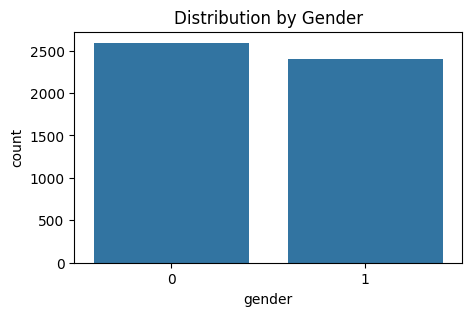

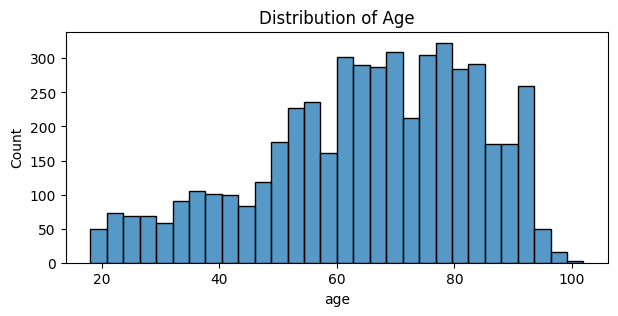

In [59]:
# Merge comorbidity score into model_df
if 'comorbidity_score' in comorbidity_df.columns:
    model_df = model_df.merge(comorbidity_df[['hadm_id', 'comorbidity_score']], on='hadm_id', how='left')
print(model_df.head())
# Data Exploration: Distribution by Gender, Race, and Diagnoses
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution by gender
plt.figure(figsize=(5,3))
sns.countplot(x='gender', data=model_df)
plt.title('Distribution by Gender')
plt.show()



# Distribution by age
plt.figure(figsize=(7,3))
sns.histplot(model_df['age'], bins=30)
plt.title('Distribution of Age')
plt.show()

# Distribution by diagnoses (if available)
if 'diagnosis' in model_df.columns:
    plt.figure(figsize=(7,3))
    sns.countplot(y='diagnosis', data=model_df, order=model_df['diagnosis'].value_counts().index[:10])
    plt.title('Top 10 Diagnoses')
    plt.show()

## 4. Split Data into Train and Test Sets

Split the processed dataset into training and testing sets for model development and evaluation.

In [61]:
# Drop datetime and 'gender' columns for modeling
datetime_cols = ['admittime', 'dischtime', 'deathtime']
# Drop subject_id, hadm_id, datetime columns, and consolidate diagnosis_x and diagnosis_y columns
drop_cols = ['subject_id', 'hadm_id'] + datetime_cols

# Consolidate diagnosis_x and diagnosis_y columns by summing them
diag_categories = [
    'blood', 'circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
    'infectious', 'injury', 'mental', 'misc', 'muscular', 'neoplasms', 'nervous',
    'pregnancy', 'prenatal', 'respiratory', 'skin'
]
for cat in diag_categories:
    x_col = f'{cat}_x'
    y_col = f'{cat}_y'
    if x_col in X_train.columns and y_col in X_train.columns:
        X_train[f'{cat}'] = X_train[x_col].fillna(0) + X_train[y_col].fillna(0)
        X_test[f'{cat}'] = X_test[x_col].fillna(0) + X_test[y_col].fillna(0)

# Drop the original diagnosis_x and diagnosis_y columns
diag_x_cols = [f'{cat}_x' for cat in diag_categories if f'{cat}_x' in X_train.columns]
diag_y_cols = [f'{cat}_y' for cat in diag_categories if f'{cat}_y' in X_train.columns]
X_train_clean = X_train.drop(columns=drop_cols + diag_x_cols + diag_y_cols + ['gender'])
X_test_clean = X_test.drop(columns=['gender'] + diag_x_cols + diag_y_cols + drop_cols)

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Ensure dense output in case imputer returns a sparse matrix
X_train_imputed = imputer.fit_transform(X_train_clean)
if hasattr(X_train_imputed, "toarray"):
    X_train_imputed = X_train_imputed.toarray()
X_train_clean = pd.DataFrame(X_train_imputed, columns=X_train_clean.columns, index=X_train_clean.index)

X_test_imputed = imputer.transform(X_test_clean)
if hasattr(X_test_imputed, "toarray"):
    X_test_imputed = X_test_imputed.toarray()
X_test_clean = pd.DataFrame(X_test_imputed, columns=X_test_clean.columns, index=X_test_clean.index)

In [62]:
# Split data into train and test sets
X = model_df.drop(columns=['mortality'])
y = model_df['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (4000, 44)
Test shape: (1000, 44)


## 5. Train and Predict with Four Machine Learning Models

Train four models (Logistic Regression, Random Forest, XGBoost, Support Vector Machine) to predict mortality, and generate predictions.

In [63]:
from sklearn.impute import SimpleImputer



# Fine-tuned models with parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=7),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=7, learning_rate=0.1),
    'SVM': SVC(probability=True, kernel='rbf', C=1.0)
}

results = {}
for name, model in models.items():
    model.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)
    results[name] = {'model': model, 'y_pred': y_pred}
    print(f'{name} training and prediction done.')

Logistic Regression training and prediction done.
Random Forest training and prediction done.


/Users/jpmclogin/Documents/MSAI/Deep Learning/homework2/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training and prediction done.
SVM training and prediction done.


## 6. Evaluate Models using R² and RMSE

Calculate R² and RMSE for each model on the test set to assess performance.

Logistic Regression: R² = 0.164, RMSE = 0.457
Random Forest: R² = 0.160, RMSE = 0.458
XGBoost: R² = 0.188, RMSE = 0.451
SVM: R² = 0.172, RMSE = 0.455


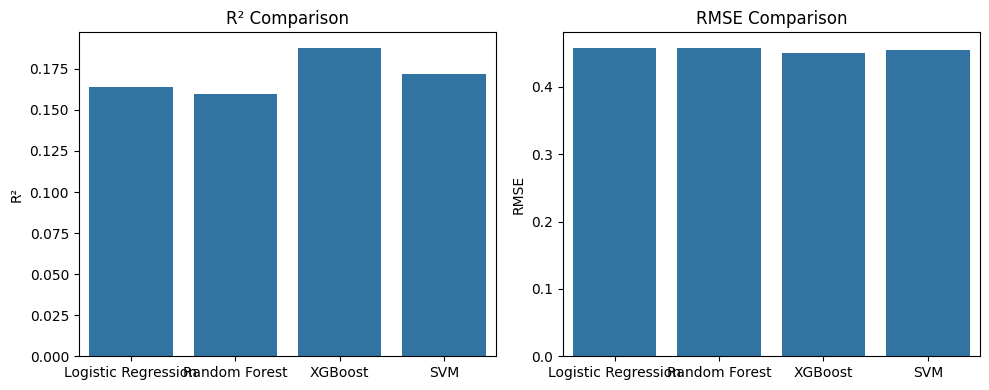

In [64]:
# Evaluate models using R² and RMSE
for name, result in results.items():
    y_pred = result['y_pred']
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{name}: R² = {r2:.3f}, RMSE = {rmse:.3f}')
    results[name]['r2'] = r2
    results[name]['rmse'] = rmse

# Plot comparison of models for R2 and RMSE
model_names = list(results.keys())
r2_scores = [results[m]['r2'] for m in model_names]
rmse_scores = [results[m]['rmse'] for m in model_names]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(x=model_names, y=r2_scores)
plt.title('R² Comparison')
plt.ylabel('R²')

plt.subplot(1,2,2)
sns.barplot(x=model_names, y=rmse_scores)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

Logistic Regression: Accuracy=0.791, Precision=0.781, Recall=0.801, F1=0.791


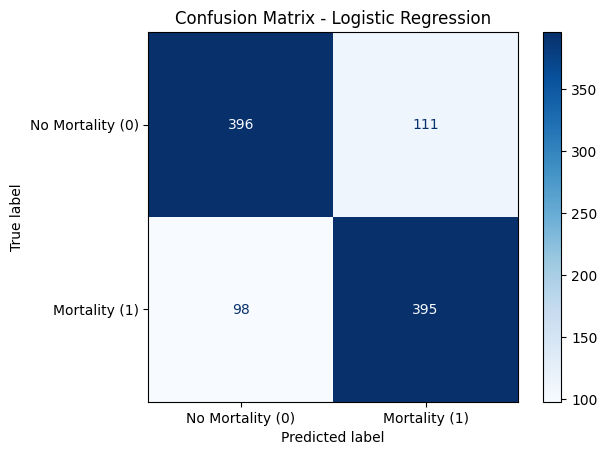

Random Forest: Accuracy=0.790, Precision=0.778, Recall=0.803, F1=0.790


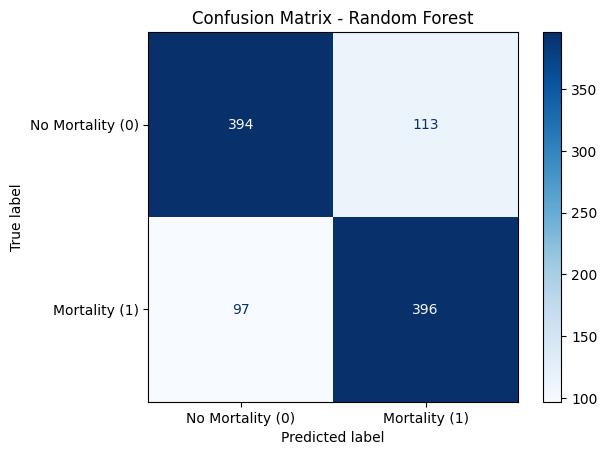

XGBoost: Accuracy=0.797, Precision=0.779, Recall=0.822, F1=0.800


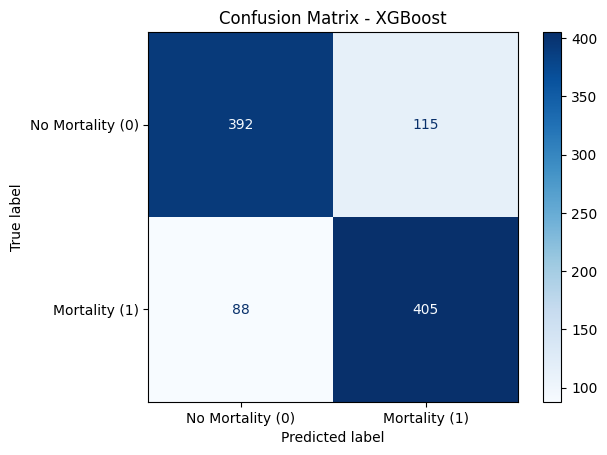

SVM: Accuracy=0.793, Precision=0.769, Recall=0.830, F1=0.798


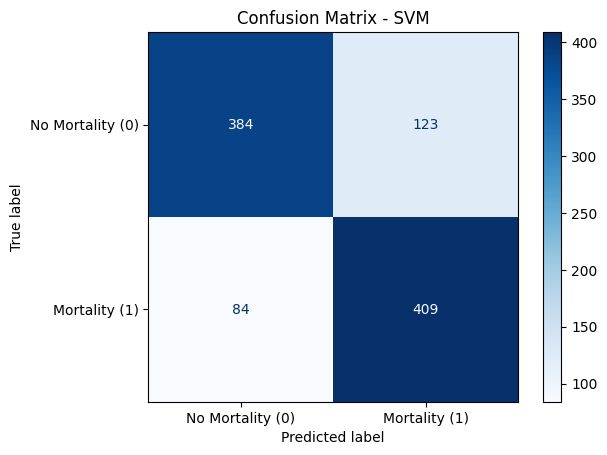

In [67]:
# Confusion matrix for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, result in results.items():
    y_pred = result['y_pred']
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name}: Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Mortality (0)", "Mortality (1)"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


## 7. Analyze Feature Importance

Extract and visualize feature importance from tree-based models and coefficients from linear models.

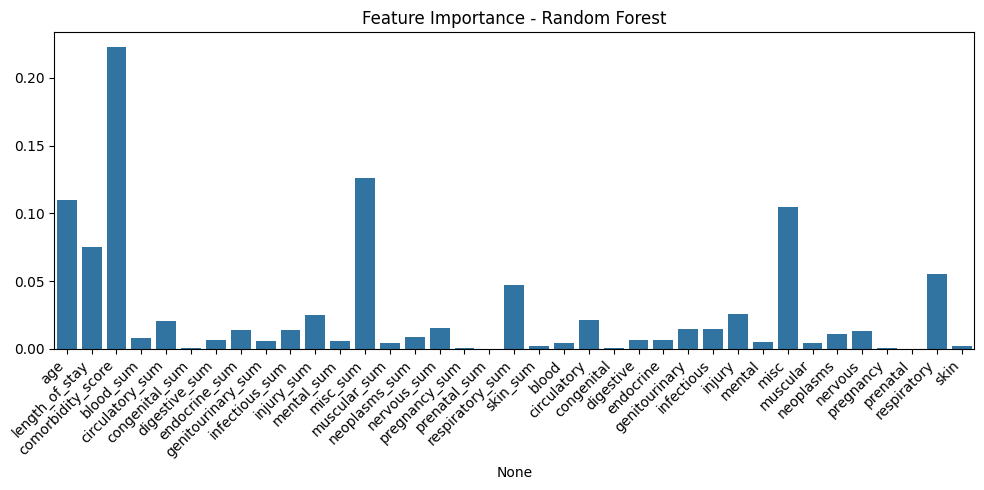

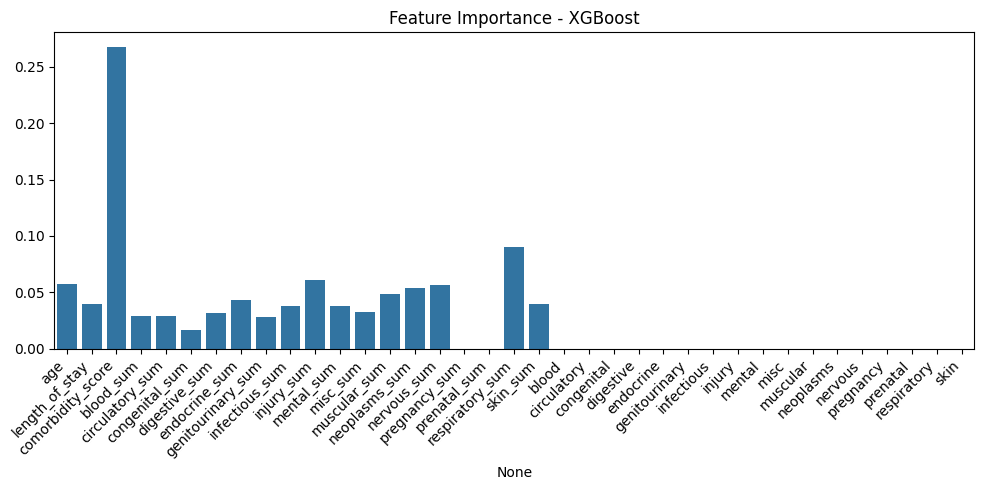

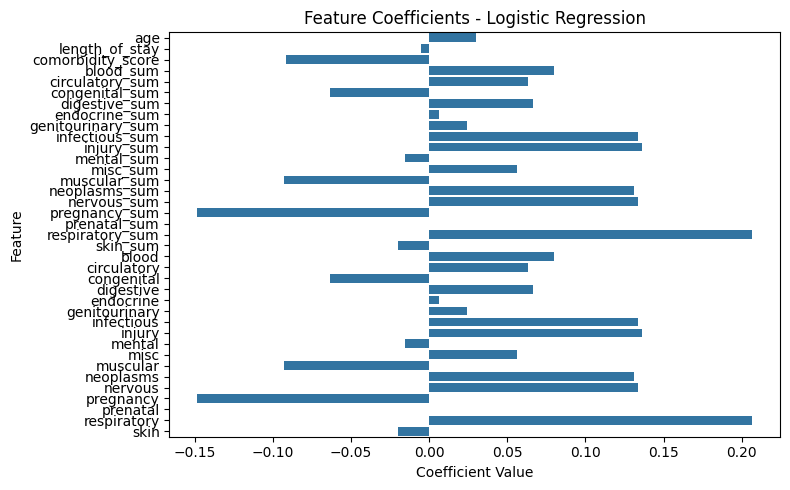

In [68]:
# Feature importance for tree-based models
for name in ['Random Forest', 'XGBoost']:
    model = results[name]['model']
    importances = model.feature_importances_
    feature_names = X_train_clean.columns
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_names, y=importances)
    plt.title(f'Feature Importance - {name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Coefficients for linear model
lr_model = results['Logistic Regression']['model']
if hasattr(lr_model, 'coef_'):
    coef = lr_model.coef_[0]
    feature_names = X_train_clean.columns
    plt.figure(figsize=(8, 5))
    sns.barplot(x=coef, y=feature_names, orient='h')
    plt.title('Feature Coefficients - Logistic Regression')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()